In [17]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from copy import copy

In [16]:
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "STIXGeneral"
mpl.rcParams["font.size"] = "10"
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rc('lines', lw=2.0)
mpl.rc('axes', lw=1.0)
mpl.rc('xtick.major', size=4, width=1.0)
mpl.rc('ytick.major', size=4, width=1.0)
mpl.rc('xtick.minor', size=2, width=0.8)
mpl.rc('ytick.minor', size=2, width=0.8)
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10 
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 10

In [6]:
import sys
import os
sys.path.append("../../")

In [50]:
from axion_kSZ_source.auxiliary.helper_functions import is_array
from axion_kSZ_source.theory.cosmology import Cosmology, CosmologyCustomH
from axion_kSZ_source.auxiliary.cosmo_db import CosmoDB
from axion_kSZ_source.auxiliary.integration_helper import IntegrationHelper
from axion_kSZ_source.axion_camb_wrappers.run_axion_camb import AxionCAMBWrapper
from axion_kSZ_source.auxiliary.survey_helper import StageII,StageIII,StageIV,SurveyType
from axion_kSZ_source.fisher_analysis.compute_mpv import compute_mean_pairwise_velocity

In [113]:
r_vals = np.arange(20.0, 180.0, 2.0)
out_folder = "/scratch/r/rbond/gfarren/axion_kSZ/fisher_outputs/sharpK_final_StageIV/"
prefix_derivs = "sharpK_5point_FFTLog_approx_test_derivs"
prefix_fisher = "sharpK_5point_FFTLog_approx_test_fisher_matrices"
axion_abundances = np.array([1.0e-04, 1.6e-04, 2.5e-04, 4.0e-04, 6.3e-04, 1.0e-03, 1.6e-03, 2.5e-03, 4.0e-03, 6.3e-03, 1.0e-02, 1.6e-02, 2.5e-02, 4.0e-02, 5.3e-02, 6.3e-02, 1.0e-01, 1.1e-01, 1.6e-01, 2.1e-01, 2.5e-01, 2.6e-01, 3.2e-01, 3.7e-01, 4.0e-01, 4.2e-01, 4.7e-01, 5.3e-01, 5.8e-01, 6.3e-01, 6.8e-01, 7.4e-01, 7.9e-01, 8.4e-01, 8.9e-01, 9.5e-01])
fractional_step_sizes = np.array([0.05, 0.1, 0.2, 0.4])
axion_masses=[1e-27, 1e-26, 1e-25]
deriv_labels = [r"$h$", r"$\omega_{\rm{DM}}$", r"$\omega_b$", r"$n_s$", "$A_s$", r"$\eta_{\rm{axion}}$"]
axion_plot_abundances=[1e-4, 0.01, 0.1, 0.68, 0.95]

In [114]:
cosmo_database="/scratch/r/rbond/gfarren/axion_kSZ/CAMB_outputs/cosmo_db_final.dat"
cosmoDB = CosmoDB(cosmo_database)
intHelper = IntegrationHelper(1024)

In [115]:
derivs = []
cosmos = []
camb_wrappers = []
for i, ma in enumerate(axion_masses):
    cosmo = CosmologyCustomH.generate(axion_frac=0.4, m_axion=ma)
    ID, ran_TF, successful_TF, out_path, log_path = cosmoDB.get_by_cosmo(cosmo)
    file_root = os.path.basename(out_path)
    root_path = out_path[:-len(file_root)]
    wrapper = AxionCAMBWrapper(root_path, file_root, log_path)
    cosmo.set_H_interpolation(wrapper.get_hubble)
    cosmos.append(cosmo)
    camb_wrappers.append(wrapper)
    
    derivs.append(np.load(out_folder+prefix_derivs+f"_ma={ma:.3E}.npy"))
fid_values = [cosmos[0].h, cosmos[0].omegaDM, cosmos[0].omegaB, cosmos[0].n_s, cosmos[0].A_s, 0.4]

In [116]:
fid_values[0]

0.6737

In [117]:
velocities = []
delta_r = 2.0
rMin=1.0e-2
r_vals = np.arange(20.0, 180.0, delta_r)
survey = StageIV(Cosmology())
window="sharp_k"
kMin,kMax=1.0e-4,1.0e2
for i, ma in enumerate(axion_masses):
    velocities.append(compute_mean_pairwise_velocity(r_vals, rMin, cosmos[i], camb_wrappers[i], survey, window=window, old_bias=False, jenkins_mass=False, integrationHelper=intHelper, kMin=kMin, kMax=kMax, do_unbiased=True, get_correlation_functions=False, use_approximations=True, use_FFTLog=True))

/gpfs/fs1/home/r/rbond/gfarren/.defaultEnv/lib/python3.8/site-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "
../../axion_kSZ_source/theory/halo_bias_base.py:29: RuntimeWarning: The given value of k_max=1.00E+02 is not feasible because you chose a sharp-k filter and a maximum mass of m_min=4.04E+13. k_max has instead be set to 3.85E-01
  warnings.warn(f"The given value of k_max={kMax:.2E} is not feasible because you chose a sharp-k filter and a maximum mass of m_min={mMin:.2E}. k_max has instead be set to {1 / self.radius_of_mass(mMin):.2E}", RuntimeWarning)
/gpfs/fs1/home/r/rbond/gfarren/.defaultEnv/lib/python3.8/site-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of e

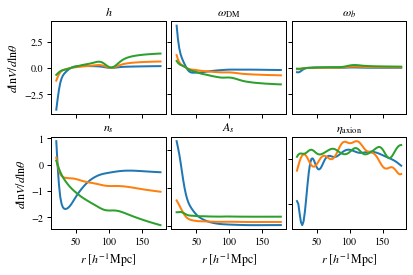

In [147]:
fig=plt.figure(figsize=(7.05,3.5))

gs = gridspec.GridSpec(ncols=3, nrows=2, figure=fig, height_ratios=[1,1], hspace=0.25, wspace=0.05, left=0.2, top=0.95)

axs=[]
for j in range(2):
    for i in range(3):
        if j==0:
            axs.append(fig.add_subplot(gs[j,i], sharey=axs[0] if i>=1 else None))
        else:
            axs.append(fig.add_subplot(gs[j,i], sharex=axs[i]))
for i_d, label in enumerate(deriv_labels):
    axs[i_d].set_title(deriv_labels[i_d])
    for i_m, ma in enumerate(axion_masses):
        p=axs[i_d].plot(r_vals, derivs[i_m][0,i_d,0,:]*fid_values[i_d]/velocities[i_m][0][0])
        #axs[i_d].plot(r_vals, derivs[i_m][0,i_d,3,:]*fid_values[i_d]/velocities[i_m][0][3], linestyle="dashed", color=p[0].get_color())
        
    if i_d%3!=0:
        [label.set_visible(False) for label in axs[i_d].get_yticklabels()]
    if i_d<3:
        [label.set_visible(False) for label in axs[i_d].get_xticklabels()]
axs[0].set_ylabel(r"$d\ln V/d\ln\theta$")
axs[3].set_ylabel(r"$d\ln V/d\ln\theta$")
for i in range(3,6):
    axs[i].set_xlabel(r"$r$ [$h^{-1} \rm{Mpc}$]")
#ax1.set_ylabel(r"$\frac{d\ln V}{d\ln \theta}$")
#ax1.legend(ncol=2)